<div align="center">

<img src="figures/UOL_Logo_Blau.png" alt="UOL Logo" width="200"/>

# Parametric Study of a Walk-In Freezer for Renewable Energy Heat

## Exploring Sustainable Solutions for Cold Storage

*Date: February 8, 2024*

*Juan Manuel Boullosa Novo, Alberto Jimenez Haro, Emre Atalan*

*[@boujuan](https://github.com/boujuan), [@albertoIWES](https://github.com/albertoIWES), [@emresevket](https://github.com/emresevket)*

[GitHub Repository](https://github.com/boujuan/Renewable_Energy_Heat)

---
<img src="figures/coldroom_render.png?render=3" alt="Cute render of our cold room - Made by @boujuan" width="600"/>

</div>


**Requirements:**
- numpy
- pandas
- matplotlib
- jupyter (obviously)
- fluprodia
- _roomClass.py (included in source code)

In [1]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
# from matplotlib.animation import FuncAnimation
from fluprodia import FluidPropertyDiagram
# from IPython.display import HTML
import _roomClass as rc # Custom class required ./_roomClass.py 

Function definition for cooling demand calculation

In [2]:
def calculate_cooling_demand(location, coldRoom):
    cooling_demand = location.calculate_yearly_cooling_demand(coldRoom)
    rc.Plotter.plot_cooling_demand(location.months, cooling_demand, location.average_temperatures)
    print("Cooling demand for each month:")
    for month, demand in zip(location.months, cooling_demand):
        print(f"{month}: {demand:.2f} W")
    print(f"Average cooling demand: {np.mean(cooling_demand):.2f} W")
    return cooling_demand

Selection of parameters of location and room.
Creation of class instance objects.

In [3]:
average_temperature_hamburg = [1.7, 2, 4.5, 9.1, 13.3, 16.3, 18.5, 18.1, 14.9, 10.5, 6, 3] 
# in °C [Source: https://en.climate-data.org/europe/germany/hamburg/hamburg-69/]
desired_freezer_temperature = -18 # in °C
coldroom_dimensions = [4, 3, 2] # in meters
floor_material = "Concrete"
wall_material = "Polyurethane foam"
ceiling_material = "Polyurethane foam"
floor_thickness = 20 # cm
wall_thickness = 10 # cm
ceiling_thickness = 13 # cm

coldRoom = rc.Room(coldroom_dimensions, floor_material, wall_material, ceiling_material, 
                   floor_thickness, wall_thickness, ceiling_thickness, desired_freezer_temperature)    
hamburg = rc.ClimateData(average_temperature_hamburg)

In [4]:
x=coldRoom._total_surface_area()
print(f"The cold room has a total contact surface area of {x:.2f} m²")

The cold room has a total contact surface area of 52.00 m²


Yearly cooling demand in Hamburg

Average yearly temperature: 9.83°C
Cooling demand for each month:
Jan: 291.38 W
Feb: 295.82 W
Mar: 332.79 W
Apr: 400.83 W
May: 462.95 W
Jun: 507.32 W
Jul: 539.86 W
Aug: 533.95 W
Sep: 486.62 W
Oct: 421.54 W
Nov: 354.98 W
Dec: 310.61 W
Average cooling demand: 411.55 W


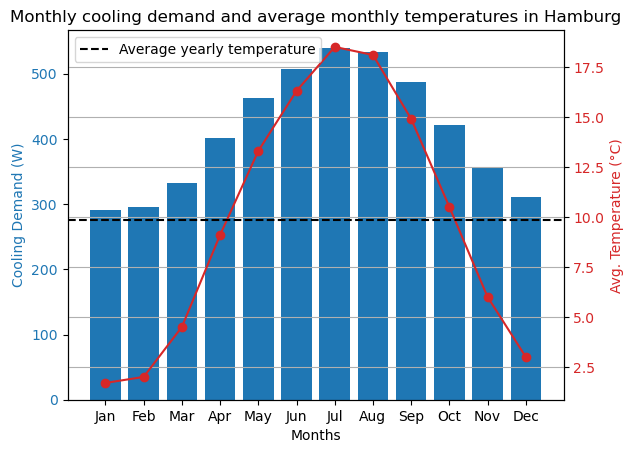

In [5]:
yearly_cooling_demand = calculate_cooling_demand(hamburg, coldRoom) # in W

Duration Curve

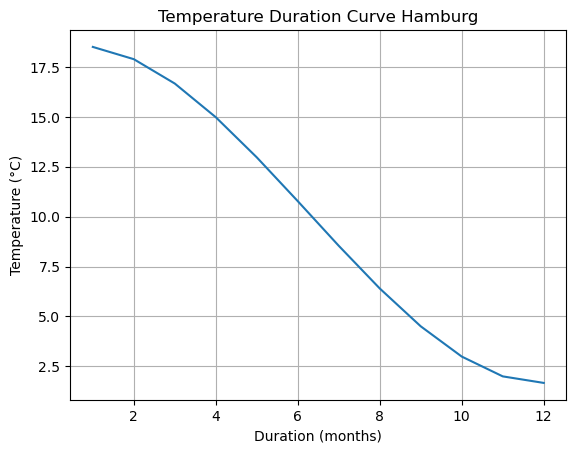

In [6]:
rc.Plotter.plot_temperature_duration_curve(hamburg.average_temperatures) # in °C

Functions definition for evaporator heat, power and cop

In [7]:
def cop_and_heat_calculations(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation.

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s., heat_evap in W
    power = m * abs(h_3 - h_2) # compressor power in W
    # print(f"Power: {power}")
    cop = heat_evap / power
    heat_cond = abs(heat_evap) - power

    cop_carnot = abs(temp_2 / (temp_2 - temp_4))
    efficiency_hp = cop / cop_carnot
    
    return m, power, cop, heat_cond, cop_carnot, efficiency_hp

def cop_calculation_power_fixed(fluid, temp_2, temp_4, efficiency_compressor, heat_evap, power):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4
    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor

    m = power / abs(h_3 - h_2)
    cop = heat_evap / power
    heat_cond = abs(heat_evap) - power

    cop_carnot = abs(temp_2 / (temp_2 - temp_4))
    efficiency_hp = cop / cop_carnot
    
    return m, cop, heat_cond, cop_carnot, efficiency_hp

def steady_state_cop_analysis(fluid_list, temp_list, fixed_temp, efficiency_compressor, heat_evap, mode='evap'):
    cop_list = []
    carnot_cop_list = []
    eff_list = []
    power_list = []
    for fluid in fluid_list:
        for temp in temp_list:
            if mode == 'evap':
                _, power, cop, _, cop_carnot, efficiency_hp = \
                    cop_and_heat_calculations(fluid, temp, fixed_temp, efficiency_compressor, heat_evap)
            else:
                _, power, cop, _, cop_carnot, efficiency_hp = \
                    cop_and_heat_calculations(fluid, fixed_temp, temp, efficiency_compressor, heat_evap)
            cop_list.append(cop)
            carnot_cop_list.append(cop_carnot)
            eff_list.append(efficiency_hp)
            power_list.append(power)
    return cop_list, carnot_cop_list, eff_list, power_list

def monthly_cop_and_heat_calculations(fluid, evap_temp, cond_temp_monthly, efficiency_compressor, months, heat_list, power_input):
    results_dict = {}
    for month, cond_temp, heat_evap in zip(months, cond_temp_monthly, heat_list):
        # print((month, heat_evap))
        _, cop_month, _, cop_carnot_month, efficiency_hp_month = \
            cop_calculation_power_fixed(fluid, evap_temp, cond_temp, efficiency_compressor, heat_evap, power_input)
        results_dict[month] = {
            'cop_month': cop_month,
            'cop_carnot_month': cop_carnot_month,
            'efficiency_hp_month': efficiency_hp_month
        }
    return results_dict


Selection of parameters for the study. We consider ±10 K from the chosen evaporator and condensator temperatures.

In [8]:
outside_temp = hamburg.average_yearly_temp + 273.15 # in K
desired_temp = desired_freezer_temperature + 273.15 # in K

# Evaporating and condensing temperatures
evap_temp = desired_temp - 10 # in K
print(f"Evaporating temperature: {evap_temp-273.15:.2f} K")
cond_temp = outside_temp + 20 # in K
print(f"Condensing temperature: {cond_temp-273.15:.2f} K")
cond_temp_monthly = [temp + 293.15 for temp in hamburg.average_temperatures] # in K with 20°C added

# Range of evaporating and condensing temperatures
evap_temp_list = np.arange(evap_temp - 10 , evap_temp + 10 , 2) # in K
cond_temp_list = np.arange(cond_temp - 10 , cond_temp + 10 , 2) # in K

print(f"Evaporating temperature range: {evap_temp_list}"
      f"\nCondensing temperature range: {cond_temp_list}")

# Fluids and parameters
fluid_list = ["R717", "R134a", "R290", "R600a", "R404a", "R407c", "R410a"]
efficiency_compressor = 0.8 # Efficiency assumed to be 80%
heat_evap = abs(coldRoom.total_power_demand(outside_temp)) # Nominal yearly heat power demand (W)
print(f"Nominal heat power demand: {heat_evap:.2f} W")

Evaporating temperature: -28.00 K
Condensing temperature: 29.82 K
Evaporating temperature range: [235.15 237.15 239.15 241.15 243.15 245.15 247.15 249.15 251.15 253.15]
Condensing temperature range: [292.975 294.975 296.975 298.975 300.975 302.975 304.975 306.975 308.975
 310.975]
Nominal heat power demand: 411.55 W


Heat demand Bar chart for different insulation materials in our room

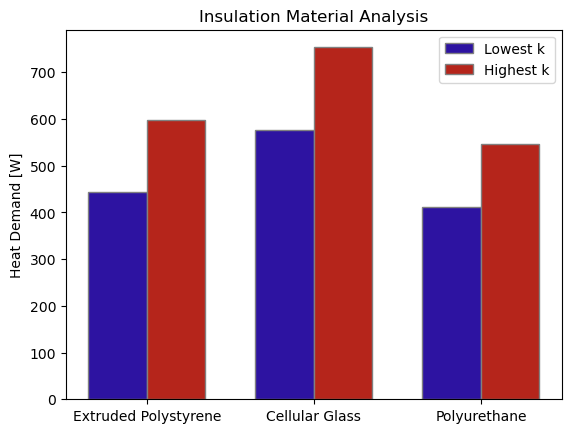

In [9]:
insul_mater_list = [
    "Extruded Polystyrene lowest",
    "Extruded Polystyrene highest",
    "Cellular Glass lowest",
    "Cellular Glass highest",
    "Polyurethane lowest",
    "Polyurethane highest",
]

insul_mat_heat_dict = {}
for material in insul_mater_list:
    coldRoom_material_comp = rc.Room(coldroom_dimensions, floor_material, material, material, 
                    floor_thickness, wall_thickness, ceiling_thickness, desired_freezer_temperature) 
    heat_evap_val = abs(coldRoom_material_comp.total_power_demand(outside_temp)) # Nominal yearly heat power demand (W)
    insul_mat_heat_dict[material] = heat_evap_val

# Extracting data for plotting
materials = ['Extruded Polystyrene', 'Cellular Glass', 'Polyurethane']
lowest_values = [insul_mat_heat_dict[f'{material} lowest'] for material in materials]
highest_values = [insul_mat_heat_dict[f'{material} highest'] for material in materials]

# Bar width and positions
bar_width = 0.35
r1 = np.arange(len(materials))
r2 = [x + bar_width for x in r1]

# Plotting the bars
plt.bar(r1, lowest_values, color='#2d13a1', width=bar_width, edgecolor='grey', label='Lowest k')
plt.bar(r2, highest_values, color='#b5251b', width=bar_width, edgecolor='grey', label='Highest k')

# Adding labels and title
#plt.xlabel('InsulationMaterials')
plt.ylabel('Heat Demand [W]')
plt.title('Insulation Material Analysis')
plt.xticks([r + bar_width/2 for r in range(len(materials))], materials)

# Adding legend
plt.legend()
plt.savefig('figures/insulation_material_analysis.png', dpi=300, transparent=True)

Steady State COP Analysis

In [10]:
steady_state_cop_list_evap, steady_state_carnot_cop_list_evap, steady_state_eff_list_evap, steady_state_power_list = \
    steady_state_cop_analysis(fluid_list, evap_temp_list, cond_temp, efficiency_compressor, heat_evap, 'evap')
steady_state_cop_list_cond, steady_state_carnot_cop_list_cond, steady_state_eff_list_cond, steady_state_power_list = \
    steady_state_cop_analysis(fluid_list, cond_temp_list, evap_temp, efficiency_compressor, heat_evap, 'cond')

Steady State Analysis Results.

In [11]:
refrigerants = ["R717 (Ammonia)", "R134a", "R290 (Propane)", "R600a (Isobutane)", "R404a", "R407c", "R410a"]

# Print results of steady state analysis
print("{:<28} | {:<27} | {:<17} | {:<5} | {:<10} | {:<10} | {:<10}".format("Evaporating temperature (°C)", "Condensing temperature (°C)", "Refrigerant", "COP", "Carnot COP", "Efficiency", "Power (W)"))
for i, refrigerant in enumerate(refrigerants):
    for j, temp in enumerate(evap_temp_list):
        print("{:<28.2f} | {:<27.2f} | {:<17} | {:<5.2f} | {:<10.2f} | {:<10.2f} | {:<10.2f}".format(temp - 273.15, cond_temp - 273.15, refrigerant, steady_state_cop_list_evap[i*len(evap_temp_list) + j], steady_state_carnot_cop_list_evap[j], steady_state_eff_list_evap[i*len(evap_temp_list) + j], steady_state_power_list[i*len(evap_temp_list) + j]))
    for j, temp in enumerate(cond_temp_list):
        print("{:<28.2f} | {:<27.2f} | {:<17} | {:<5.2f} | {:<10.2f} | {:<10.2f} | {:<10.2f}".format(evap_temp - 273.15, temp - 273.15, refrigerant, steady_state_cop_list_cond[i*len(cond_temp_list) + j], steady_state_carnot_cop_list_cond[j], steady_state_eff_list_cond[i*len(cond_temp_list) + j], steady_state_power_list[i*len(cond_temp_list) + j]))

Evaporating temperature (°C) | Condensing temperature (°C) | Refrigerant       | COP   | Carnot COP | Efficiency | Power (W) 
-38.00                       | 29.82                       | R717 (Ammonia)    | 2.06  | 3.47       | 0.59       | 122.79    
-36.00                       | 29.82                       | R717 (Ammonia)    | 2.17  | 3.60       | 0.60       | 129.01    
-34.00                       | 29.82                       | R717 (Ammonia)    | 2.28  | 3.75       | 0.61       | 135.34    
-32.00                       | 29.82                       | R717 (Ammonia)    | 2.39  | 3.90       | 0.61       | 141.78    
-30.00                       | 29.82                       | R717 (Ammonia)    | 2.52  | 4.06       | 0.62       | 148.32    
-28.00                       | 29.82                       | R717 (Ammonia)    | 2.66  | 4.24       | 0.63       | 154.98    
-26.00                       | 29.82                       | R717 (Ammonia)    | 2.80  | 4.43       | 0.63       | 161

Calculate the Maximum Power (W) required in the steady state analysis for each refrigerant and set it as benchmark for our nominal power in the compressor.

Maximum power required for R717 (Ammonia): 182.80 W
Maximum power required for R134a: 195.26 W
Maximum power required for R290 (Propane): 197.57 W
Maximum power required for R600a (Isobutane): 191.68 W
Maximum power required for R404a: 227.06 W
Maximum power required for R407c: 222.96 W
Maximum power required for R410a: 206.13 W


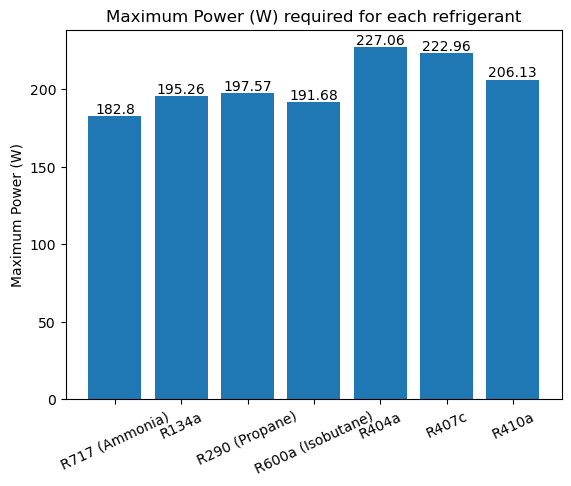

In [12]:
# Maximum Power (W) required for each refrigerant
for i, refrigerant in enumerate(refrigerants):
    print(f"Maximum power required for {refrigerant}: {max(steady_state_power_list[i*len(evap_temp_list) : (i+1)*len(evap_temp_list)]):.2f} W")
    
# Plotting Maximum Power (W) required for each refrigerant
fig, ax = plt.subplots()
bars = ax.bar(refrigerants, [max(steady_state_power_list[i*len(evap_temp_list) : (i+1)*len(evap_temp_list)]) for i in range(len(refrigerants))])
ax.set_ylabel("Maximum Power (W)")
#ax.set_xlabel("Refrigerant")
ax.set_title("Maximum Power (W) required for each refrigerant")
plt.xticks(rotation=25)

# Add the values of each bar inside them
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center')  # ha stands for horizontal alignment    
plt.savefig("figures/maximum_power_required.png", dpi=300, transparent=True)
plt.savefig("figures/maximum_power_required.pdf")

We plot the results of the Steady State Analysis

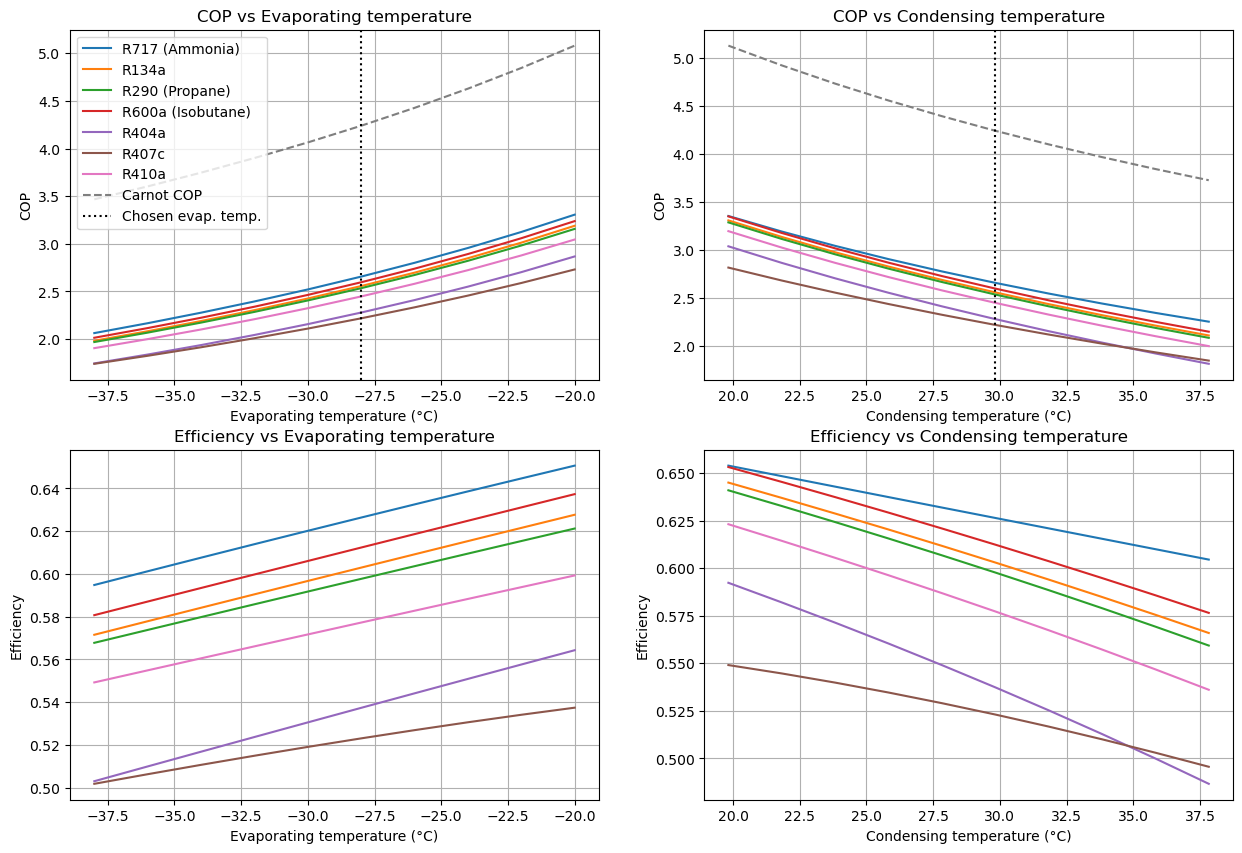

In [13]:
# Plotting
fig, ax = plt.subplots(2, 2, figsize=(15, 10))  # Change to 2x2 grid

# Plot steady state COP
for i, refrigerant in enumerate(refrigerants):
    ax[0, 0].plot(evap_temp_list - 273.15, steady_state_cop_list_evap[i*len(evap_temp_list):(i+1)*len(evap_temp_list)], label=refrigerant)
    ax[0, 1].plot(cond_temp_list - 273.15, steady_state_cop_list_cond[i*len(cond_temp_list):(i+1)*len(cond_temp_list)], label=refrigerant)

# Plot Carnot COP
ax[0, 0].plot(evap_temp_list - 273.15, steady_state_carnot_cop_list_evap[:len(evap_temp_list)], label="Carnot COP", linestyle="--")
ax[0, 1].plot(cond_temp_list - 273.15, steady_state_carnot_cop_list_cond[:len(cond_temp_list)], label="Carnot COP", linestyle="--")

# Plot chosen temperatures
ax[0, 0].axvline(x=evap_temp - 273.15, color='k', linestyle='dotted', label="Chosen evap. temp.") # Convert to °C
ax[0, 1].axvline(x=cond_temp - 273.15, color='k', linestyle='dotted', label="Chosen cond. temp.")

# Set labels and titles
ax[0, 0].set_xlabel("Evaporating temperature (°C)")
ax[0, 0].set_ylabel("COP")
ax[0, 0].set_title("COP vs Evaporating temperature")
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].set_xlabel("Condensing temperature (°C)")
ax[0, 1].set_ylabel("COP")
ax[0, 1].set_title("COP vs Condensing temperature")
# ax[0, 1].legend()
ax[0, 1].grid()

# Plot steady state efficiency
for i, refrigerant in enumerate(refrigerants):
    ax[1, 0].plot(evap_temp_list - 273.15, steady_state_eff_list_evap[i*len(evap_temp_list):(i+1)*len(evap_temp_list)], label=refrigerant) # Convert to °C
    ax[1, 1].plot(cond_temp_list - 273.15, steady_state_eff_list_cond[i*len(cond_temp_list):(i+1)*len(cond_temp_list)], label=refrigerant)
    
# Set labels and titles
ax[1, 0].set_xlabel("Evaporating temperature (°C)")
ax[1, 0].set_ylabel("Efficiency")
ax[1, 0].set_title("Efficiency vs Evaporating temperature")
# ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].set_xlabel("Condensing temperature (°C)")
ax[1, 1].set_ylabel("Efficiency")
ax[1, 1].set_title("Efficiency vs Condensing temperature")
# ax[1, 1].legend()
ax[1, 1].grid()
plt.savefig("figures/steady_state_cop_efficiency.png", dpi=300, transparent=True)

Condensated T° and evaporated T° plots for R290 in the same 3D graph to compare results

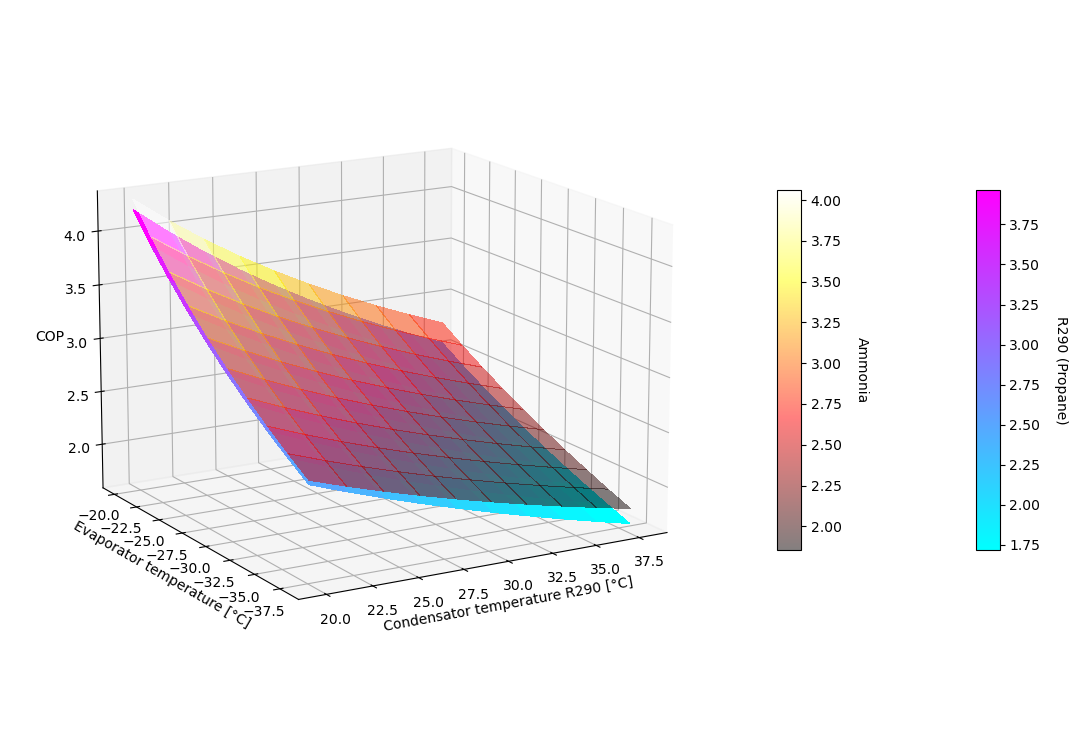

In [14]:
param_cop = pd.DataFrame(
    index=evap_temp_list, 
    columns=cond_temp_list
)

for ev_temp in evap_temp_list:
    _, _, cop, _, _, _ = cop_and_heat_calculations(
        fluid_list[2], # R290 (Propane)
        ev_temp, 
        cond_temp_list, 
        efficiency_compressor, 
        heat_evap
    )
    param_cop.loc[ev_temp] = cop

param_cop

param_cop2 = pd.DataFrame(
    index=evap_temp_list, 
    columns=cond_temp_list
)

for ev_temp in evap_temp_list:
    _, _, cop, _, _, _ = cop_and_heat_calculations(
        fluid_list[0], # (Ammonia)
        ev_temp, 
        cond_temp_list, 
        efficiency_compressor, 
        heat_evap
    )
    param_cop2.loc[ev_temp] = cop

param_cop2

# Lets animate! Yay!
# def update(frame):
#     ax.view_init(elev=20, azim=frame)
#     return surf, surf2

# Plot 3D Figure:
fig, ax = plt.subplots(1, figsize=(12, 7.5), subplot_kw={"projection": "3d"})
# fig.patch.set_alpha(0) # Transparent background

X, Y = np.meshgrid(cond_temp_list - 273.15, evap_temp_list - 273.15)

surf = ax.plot_surface(X, Y, param_cop.values, cmap=cm.cool, linewidth=0, antialiased=False)
surf2 = ax.plot_surface(X, Y, param_cop2.values, cmap=cm.hot, linewidth=0, antialiased=False, alpha=0.5)

azimuth_values = np.linspace(0, 360, 360)
# animation = FuncAnimation(fig, update, frames=azimuth_values, interval=1)

ax.set_xlabel("Condensator temperature R290 [°C]")
ax.set_ylabel("Evaporator temperature [°C]")
ax.set_zlabel("COP")
ax.view_init(elev=15, azim=240)
ax.set_box_aspect(aspect=None, zoom=0.9)

cbar1 = fig.colorbar(surf, shrink=0.5, aspect=15)
cbar1.set_label('R290 (Propane)', rotation=270, labelpad=20)  # Add label to colorbar

cbar2 = fig.colorbar(surf2, shrink=0.5, aspect=15)
cbar2.set_label('Ammonia', rotation=270, labelpad=20)  # Add label to colorbar

plt.tight_layout()
# HTML(animation.to_html5_video())
# animation.save('figures/3d_cop.gif', writer='pillow', fps=15)  # Set transparent=True
plt.savefig("figures/3d_cop.png", dpi=300, transparent=True)

<center>Animated Plot:

<img src="figures\3d_cop.gif" width="600"></center>

We plot the monthly COPs with respect to the average monthly ambient temperatures around the year.
We assume a nominal power input of 200 W


Monthly COP and Carnot COP:
Jan: COP = 1.46, Carnot COP = 4.93
Feb: COP = 1.48, Carnot COP = 4.90
Mar: COP = 1.66, Carnot COP = 4.67
Apr: COP = 2.00, Carnot COP = 4.29
May: COP = 2.31, Carnot COP = 4.00
Jun: COP = 2.54, Carnot COP = 3.81
Jul: COP = 2.70, Carnot COP = 3.69
Aug: COP = 2.67, Carnot COP = 3.71
Sep: COP = 2.43, Carnot COP = 3.90
Oct: COP = 2.11, Carnot COP = 4.19
Nov: COP = 1.77, Carnot COP = 4.54
Dec: COP = 1.55, Carnot COP = 4.81

Average yearly COP: 2.06
Average yearly efficiency: 0.50


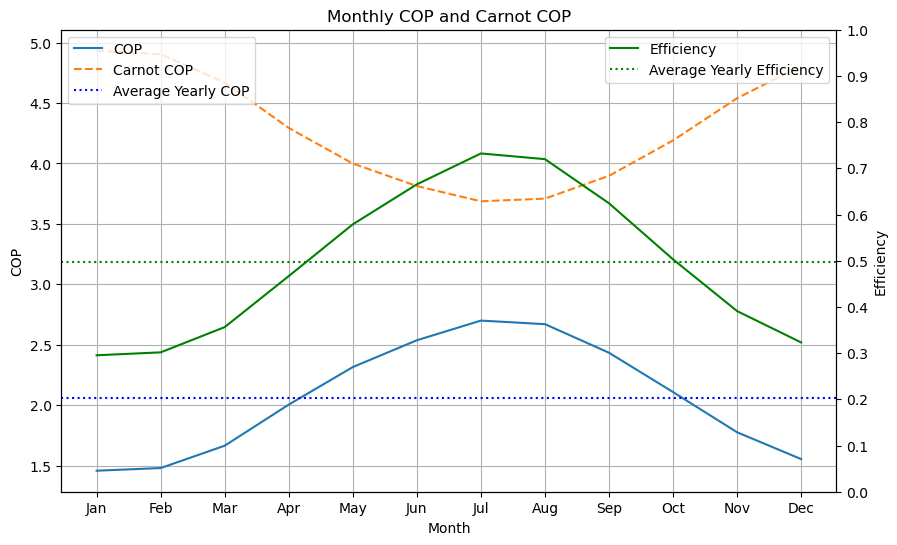

In [15]:
# Monthly COP and heat calculations
# We assume a constant Power input
power_input = 200 # W

monthly_cop_list = monthly_cop_and_heat_calculations(
    fluid_list[0],
    evap_temp, # fixed evaporating temperature in K
    cond_temp_monthly, # variable condensating temperature in K
    efficiency_compressor, 
    hamburg.months,
    yearly_cooling_demand, # W
    power_input # W
)

print("\nMonthly COP and Carnot COP:")
for month, data in monthly_cop_list.items():
    print(f"{month}: COP = {data['cop_month']:.2f}, Carnot COP = {data['cop_carnot_month']:.2f}")

# Calculate the average yearly COP
average_yearly_cop = sum([data['cop_month'] for data in monthly_cop_list.values()]) / len(monthly_cop_list)
print(f"\nAverage yearly COP: {average_yearly_cop:.2f}")

average_efficiency_hp = sum([data['efficiency_hp_month'] for data in monthly_cop_list.values()]) / len(monthly_cop_list)
print(f"Average yearly efficiency: {average_efficiency_hp:.2f}")

# Plot monthly COP with Carnot COP and Efficiency
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()  # Create a new axis that shares the same x-axis
ax.plot(hamburg.months, [data['cop_month'] for data in monthly_cop_list.values()], label="COP")
ax.plot(hamburg.months, [data['cop_carnot_month'] for data in monthly_cop_list.values()], label="Carnot COP", linestyle="--")
ax.axhline(y=average_yearly_cop, color='b', linestyle=':', label='Average Yearly COP')
ax2.plot(hamburg.months, [data['efficiency_hp_month'] for data in monthly_cop_list.values()], label="Efficiency", color='g')
ax2.axhline(y=average_efficiency_hp, color='g', linestyle=':', label='Average Yearly Efficiency')
ax.set_xlabel("Month")
ax.set_ylabel("COP")
ax.set_title("Monthly COP and Carnot COP")
ax2.set_ylabel("Efficiency")
ax2.set_ylim(0, 1)  # Set the limits of the second y-axis
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid()

plt.savefig("figures/monthly_cop_eff.png", dpi=300, transparent=True)


Let's try to plot the P-H Diagram:

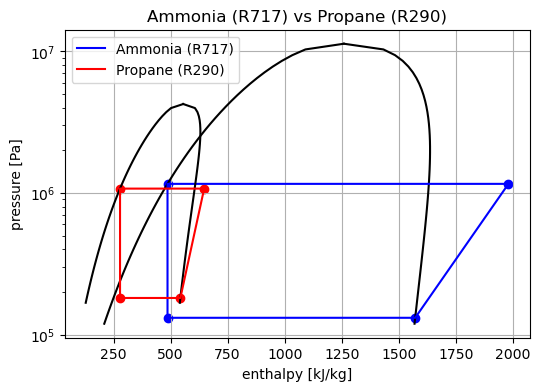

In [16]:

def press_and_enthalpy_calc(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation. unit: Pa

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s.
    power = m * abs(h_3 - h_2) # compressor power in W
    cop = abs(heat_evap) / power
    heat_cond = abs(heat_evap) - power
    
    return h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4

h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4 = press_and_enthalpy_calc(
    fluid_list[0], evap_temp, cond_temp, efficiency_compressor, heat_evap
)
h2_1, h2_2, h2_3, h2_4, press2_1, press2_2, press2_3, press2_4 = press_and_enthalpy_calc(
    fluid_list[2], evap_temp, cond_temp, efficiency_compressor, heat_evap
)

p_range = np.geomspace(PropsSI("P", "T", 273.15 -30, "Q", 0, fluid_list[0]), PropsSI("PCRIT", fluid_list[0])) # in Pa
boiling_line = PropsSI("H", "P", p_range, "Q", 0, fluid_list[0]) / 1e3
dew_line = PropsSI("H", "P", p_range, "Q", 1, fluid_list[0]) / 1e3

p_range2 = np.geomspace(PropsSI("P", "T", 273.15 -30, "Q", 0, fluid_list[2]), PropsSI("PCRIT", fluid_list[2]))
boiling_line2 = PropsSI("H", "P", p_range2, "Q", 0, fluid_list[2]) / 1e3
dew_line2 = PropsSI("H", "P", p_range2, "Q", 1, fluid_list[2]) / 1e3

plt.figure(figsize=(6, 4))
plt.yscale("log")

# Plot for Ammonia (R717)
plt.plot(boiling_line, p_range, color="#000")
plt.plot(dew_line, p_range, color="#000")
plt.scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [press_1, press_2, press_3, press_4], color='blue')
plt.plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]],
         [press_1, press_2, press_3, press_4, press_1], color='blue', label='Ammonia (R717)')

# Plot for Propane (R290)
plt.plot(boiling_line2, p_range2, color="#000")
plt.plot(dew_line2, p_range2, color="#000")
plt.scatter([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4]], [press2_1, press2_2, press2_3, press2_4], color='red')
plt.plot([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4, h2_1]],
         [press2_1, press2_2, press2_3, press2_4, press2_1], color='red', label='Propane (R290)')

plt.ylabel("pressure [Pa]")
plt.xlabel("enthalpy [kJ/kg]")
plt.title("Ammonia (R717) vs Propane (R290)")
plt.legend()
plt.grid()
plt.savefig("figures/ph_diagram_ammonia_propane.png", dpi=300, transparent=True)

# Calculate the x and y-axis limits for the plot
min_x = min(min(boiling_line), min(dew_line), min([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]]),
            min(boiling_line2), min(dew_line2), min([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4, h2_1]]))
max_x = max(max(boiling_line), max(dew_line), max([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]]),
            max(boiling_line2), max(dew_line2), max([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4, h2_1]]))
min_y = min(min(p_range), min([press_1, press_2, press_3, press_4]),
            min(p_range2), min([press2_1, press2_2, press2_3, press2_4]))
max_y = max(max(p_range), max([press_1, press_2, press_3, press_4]),
            max(p_range2), max([press2_1, press2_2, press2_3, press2_4]))
_x_lims = (min_x, max_x)
_y_lims = (min_y, max_y)

We plot the PH and TS Diagrams in the same figure in order to compare the two refrigerants

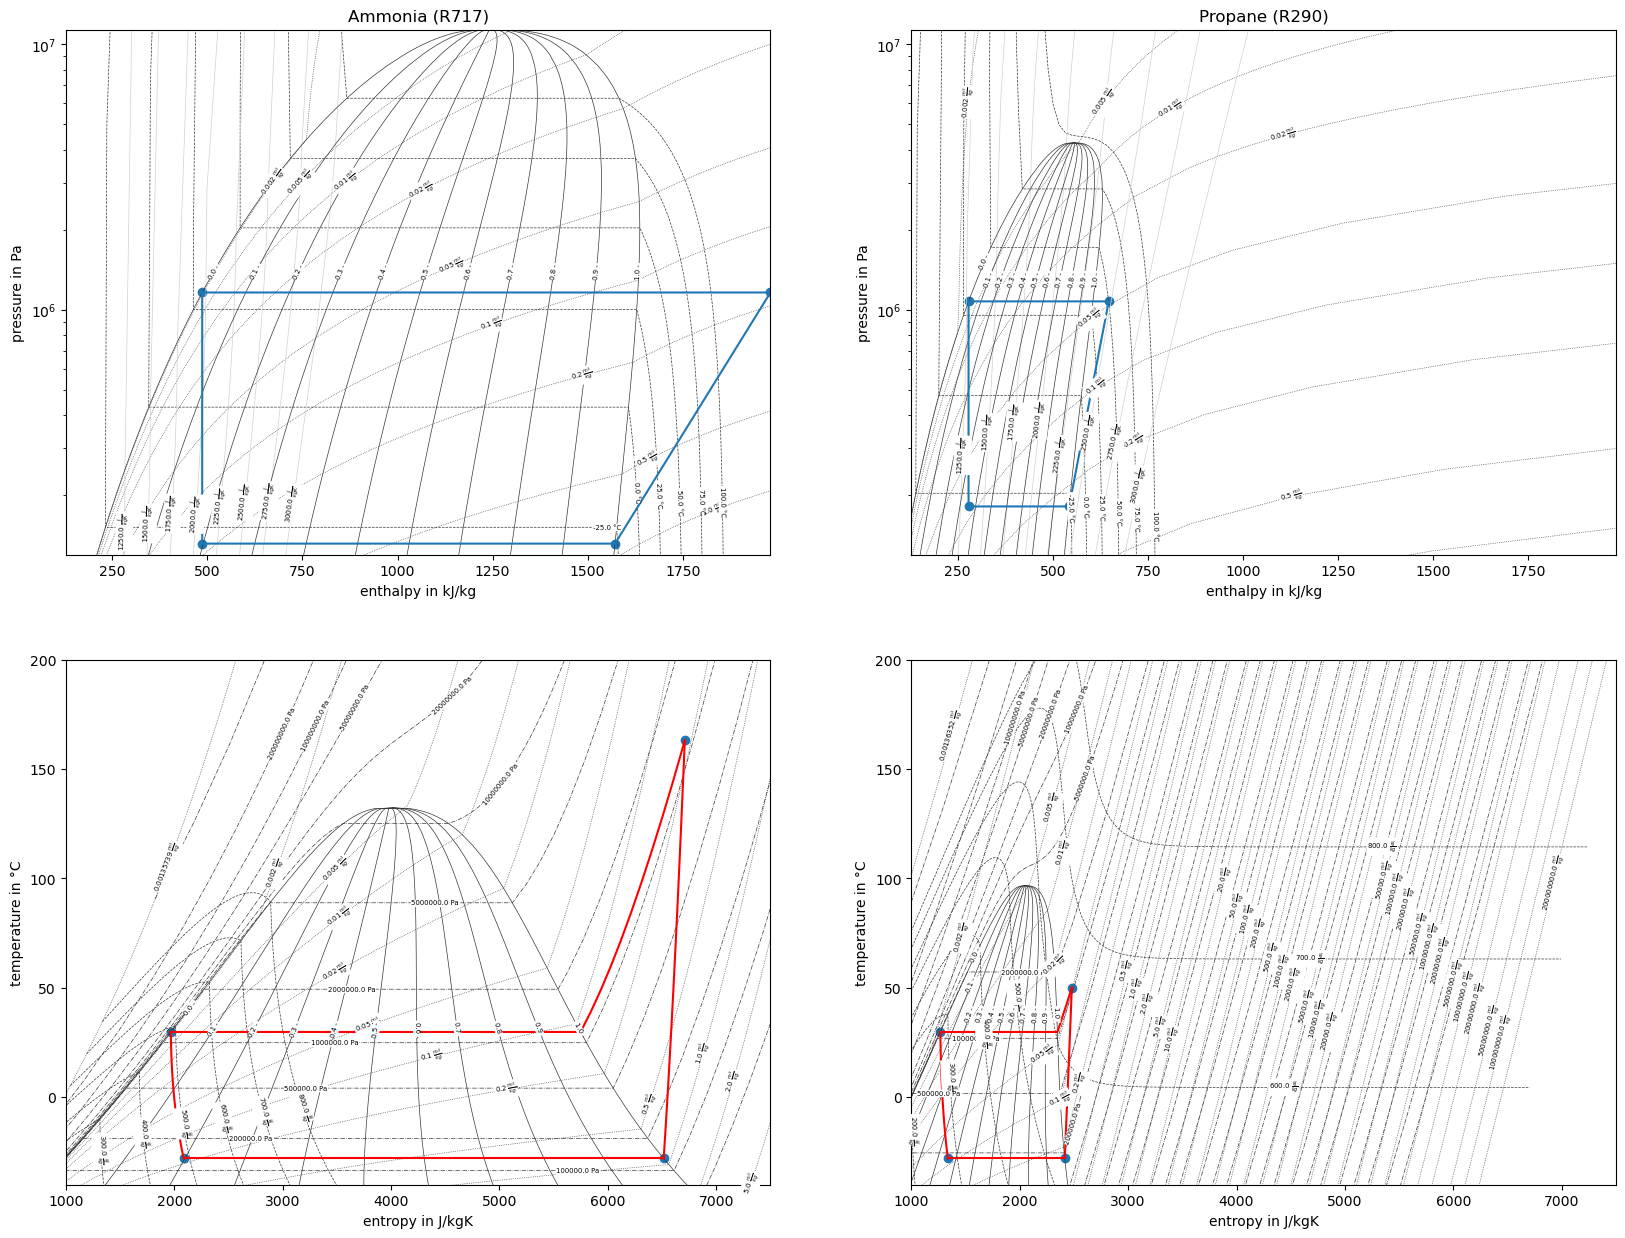

In [17]:
diagram = FluidPropertyDiagram(fluid_list[0])
diagram.set_unit_system(T="°C", h="kJ/kg")
diagram.set_isolines(T=np.arange(-25, 101, 25), s=np.arange(1250, 3001, 250), h=np.arange(100, 801, 100))
diagram.calc_isolines()

diagram2 = FluidPropertyDiagram(fluid_list[2])
diagram2.set_unit_system(T="°C", h="kJ/kg")
diagram2.set_isolines(T=np.arange(-25, 101, 25), s=np.arange(1250, 3001, 250), h=np.arange(100, 801, 100))
diagram2.calc_isolines()

fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Ammonia ph diagram

diagram.draw_isolines(fig, ax[0,0], "logph", _x_lims[0], _x_lims[1], _y_lims[0], _y_lims[1])
ax[0,0].scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [press_1, press_2, press_3, press_4])
ax[0,0].plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]], [press_1, press_2, press_3, press_4, press_1])
ax[0,0].set_ylabel("pressure in Pa")
ax[0,0].set_xlabel("enthalpy in kJ/kg")
ax[0,0].set_title("Ammonia (R717)")

# Propane ph diagram

diagram2.draw_isolines(fig, ax[0,1], "logph", _x_lims[0], _x_lims[1], _y_lims[0], _y_lims[1])
ax[0,1].scatter([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4]], [press2_1, press2_2, press2_3, press2_4])
ax[0,1].plot([h / 1e3 for h in [h2_1, h2_2, h2_3, h2_4, h2_1]], [press2_1, press2_2, press2_3, press2_4, press2_1])
ax[0,1].set_ylabel("pressure in Pa")
ax[0,1].set_xlabel("enthalpy in kJ/kg")
ax[0,1].set_title("Propane (R290)")

# Ammonia Ts diagram

diagram.draw_isolines(fig, ax[1,0], "Ts", 1000, 7500, -40, 200)

t = [] # temperature in °C
s = [] # entropy in J/kgK

for p, h in zip([press_1, press_2, press_3, press_4], [h_1, h_2, h_3, h_4]):
    t += [PropsSI("T", "P", p, "H", h, fluid_list[0]) - 273.15]
    s += [PropsSI("S", "P", p, "H", h, fluid_list[0])]
    
ax[1,0].scatter(s, t)

lines = {
    "12": {
        "isoline_property": "p",
        "isoline_value": press_1,
        "starting_point_property": "h",
        "starting_point_value": h_1 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h_2 / 1e3
    },
    "23": {
        "isoline_property": "s",
        "isoline_value": s[1],
        "isoline_value_end": s[2],
        "starting_point_property": "p",
        "starting_point_value": press_2,
        "ending_point_property": "p",
        "ending_point_value": press_3
    },
    "34": {
        "isoline_property": "p",
        "isoline_value": press_3,
        "starting_point_property": "h",
        "starting_point_value": h_3 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h_4 / 1e3
    },
    "41": {
        "isoline_property": "h",
        "isoline_value": h_4 / 1e3,
        "starting_point_property": "p",
        "starting_point_value": press_4,
        "ending_point_property": "p",
        "ending_point_value": press_1
    },
}

for line in lines.values():
    line_data = diagram.calc_individual_isoline(**line)
    ax[1,0].plot(line_data["s"], line_data["T"], color="#FF0000")

ax[1,0].set_ylabel("temperature in °C")
ax[1,0].set_xlabel("entropy in J/kgK")

# Propane Ts diagram

diagram2.draw_isolines(fig, ax[1,1], "Ts", 1000, 7500, -40, 200)

t2 = []
s2 = []

for p, h in zip([press2_1, press2_2, press2_3, press2_4], [h2_1, h2_2, h2_3, h2_4]):
    t2 += [PropsSI("T", "P", p, "H", h, fluid_list[2]) - 273.15]
    s2 += [PropsSI("S", "P", p, "H", h, fluid_list[2])]
    
ax[1,1].scatter(s2, t2)

lines2 = {
    "12": {
        "isoline_property": "p",
        "isoline_value": press2_1,
        "starting_point_property": "h",
        "starting_point_value": h2_1 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h2_2 / 1e3
    },
    "23": {
        "isoline_property": "s",
        "isoline_value": s2[1],
        "isoline_value_end": s2[2],
        "starting_point_property": "p",
        "starting_point_value": press2_2,
        "ending_point_property": "p",
        "ending_point_value": press2_3
    },
    "34": {
        "isoline_property": "p",
        "isoline_value": press2_3,
        "starting_point_property": "h",
        "starting_point_value": h2_3 / 1e3,
        "ending_point_property": "h",
        "ending_point_value": h2_4 / 1e3
    },
    "41": {
        "isoline_property": "h",
        "isoline_value": h2_4 / 1e3,
        "starting_point_property": "p",
        "starting_point_value": press2_4,
        "ending_point_property": "p",
        "ending_point_value": press2_1
    },
}

for line in lines2.values():
    line_data = diagram2.calc_individual_isoline(**line)
    ax[1,1].plot(line_data["s"], line_data["T"], color="#FF0000")
    
ax[1,1].set_ylabel("temperature in °C")
ax[1,1].set_xlabel("entropy in J/kgK")
plt.savefig("figures/ts_and_ph_diagrams.png", dpi=300, transparent=True)